In [55]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV


In [2]:
# Read the datasets 
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Combine two dataframe for later use
combine = [train_df, test_df]
all_df = pd.concat([train_df, test_df], sort = True).reset_index(drop=True)

#Snapshot of the dataset
train_df.head()
#PassengerId: Unique Id of a passenger
#Survival: Whether a passenger survived or not; 1 if survived and 0 if not.
#pclass: Ticket class
#Name: name of the passenger
#sex: Sex
#Age: Age in years
#sibsp: # of siblings / spouses aboard the Titanic
#parch: # of parents / children aboard the Titanic
#ticket: Ticket number
#fare: Passenger fare
#cabin: Cabin number
#embarked: Port of Embarkation

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_df.info()
#We can see that there are some missing data in 'age', 'cabin' and 'embarked'
#There are 11 features plus 1 target variable (Survived), we need to know the correlation among them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


In [4]:
#There are many missing values in feature "Age" and "Cabin"
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

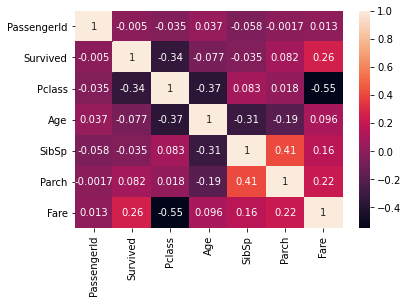

In [5]:
#"Age" is highly correlated with "Pclass"
corrMatrix = train_df.corr()
sns.heatmap(corrMatrix, annot = True)
plt.show()

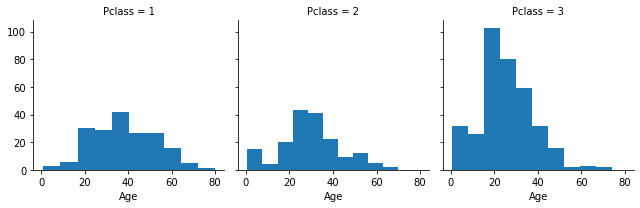

In [6]:
g = sns.FacetGrid(train_df, col='Pclass')
g.map(plt.hist, 'Age')

In [7]:
#We decide to use the median of the age by corresponding Pclass to fill the missing value
print(all_df[['Pclass', "Age"]].groupby(['Pclass']).median())

#Fill the NaN in age
for dataset in combine:
    dataset['Age'] = all_df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

         Age
Pclass      
1       39.0
2       29.0
3       24.0


In [8]:
#There are 2 missing value in Embarked
#We fill it with the mode

#Fill the NaN column by 'S' and turn them into integers
print(all_df['Embarked'].mode())
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

0    S
dtype: object


In [9]:
#add a new feature called "family size" by combining "Sibsp" and "Parch"
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] +  dataset['Parch'] + 1
    
#add another feature called "Alone"
for dataset in combine:
    dataset.loc[dataset['FamilySize'] > 1, "Alone"] = 0
    dataset.loc[dataset['FamilySize'] <= 1, "Alone"] = 1
    dataset['Alone'] = dataset['Alone'].astype(int)

In [10]:
#There are 537 people alone
train_df['Alone'].value_counts()

1    537
0    354
Name: Alone, dtype: int64

In [11]:
#Replace the 'Name' by using the according title
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Major', 'Sir', 'Jonkheer', 'Dona','Rev'], 'Other')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Dr,0.428571
1,Master,0.575000
2,Miss,0.702703
3,Mr,0.156673
4,Mrs,0.793651
5,Other,0.312500


In [12]:
#Fill the missing value in feature "Fare" with the median
for dataset in combine:
    dataset['Fare'] = dataset['Fare'].fillna(train_df['Fare'].median())

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
 12  FamilySize   891 non-null    int64  
 13  Alone        891 non-null    int32  
 14  Title        891 non-null    object 
dtypes: float64(2), int32(1), int64(6), object(6)
memory usage: 80.1+ KB


In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         418 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
 11  FamilySize   418 non-null    int64  
 12  Alone        418 non-null    int32  
 13  Title        418 non-null    object 
dtypes: float64(2), int32(1), int64(5), object(6)
memory usage: 34.4+ KB


In [15]:
train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1,Mr
5,6,0,3,"Moran, Mr. James",male,25.0,0,0,330877,8.4583,NaN,Q,1,1,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,1,1,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,5,0,Master
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,3,0,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,2,0,Mrs


# Data Visualization

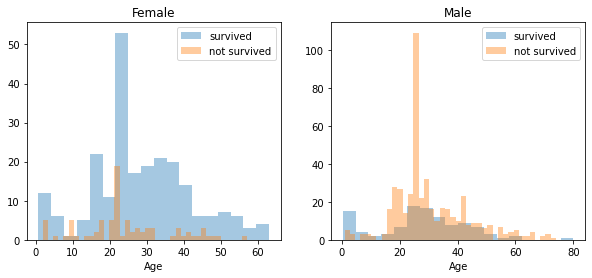

In [16]:
#Gender Plot

survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_df[train_df['Sex']=='female']
men = train_df[train_df['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age, bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age, bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age, bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age, bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

c:\users\homing\pycharmprojects\data science\venv\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


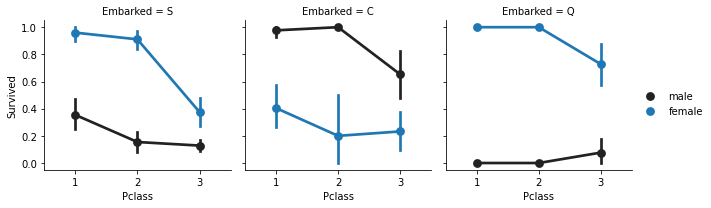

In [17]:
g = sns.FacetGrid(train_df, col='Embarked')
g = g.map(sns.pointplot, 'Pclass','Survived','Sex', hue_order = None ).add_legend()

#We can see that women had higher survival rate in Embarked S and Q, but men had higher survival rate in Emarked C

c:\users\homing\pycharmprojects\data science\venv\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


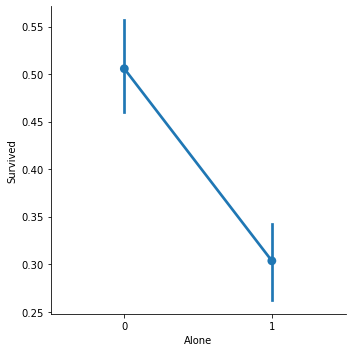

In [18]:
#Not being alone had a higher chance to survive 

sns.factorplot("Alone","Survived", data=train_df)

c:\users\homing\pycharmprojects\data science\venv\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


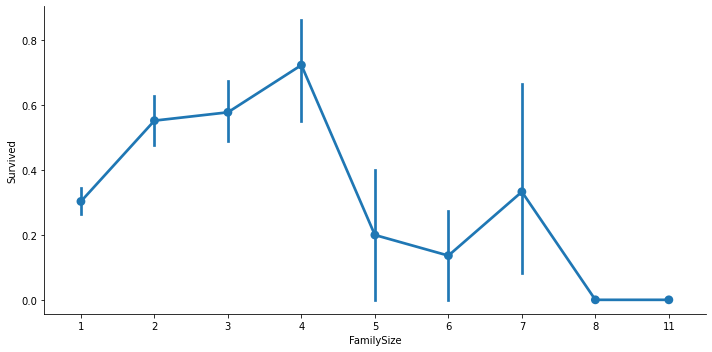

In [19]:
#Famile size of 3 & 4 had the highest survival rate

sns.factorplot("FamilySize","Survived", data=train_df, aspect = 2)

<AxesSubplot:xlabel='Fare'>

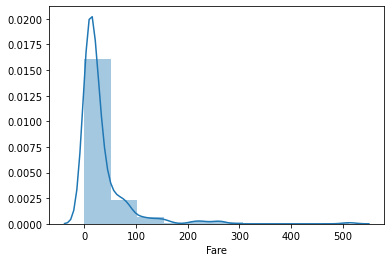

In [20]:
#We can see that the feature "Fare" is extremely positve skewed

sns.distplot(train_df['Fare'], bins =10)

<AxesSubplot:xlabel='Fare', ylabel='count'>

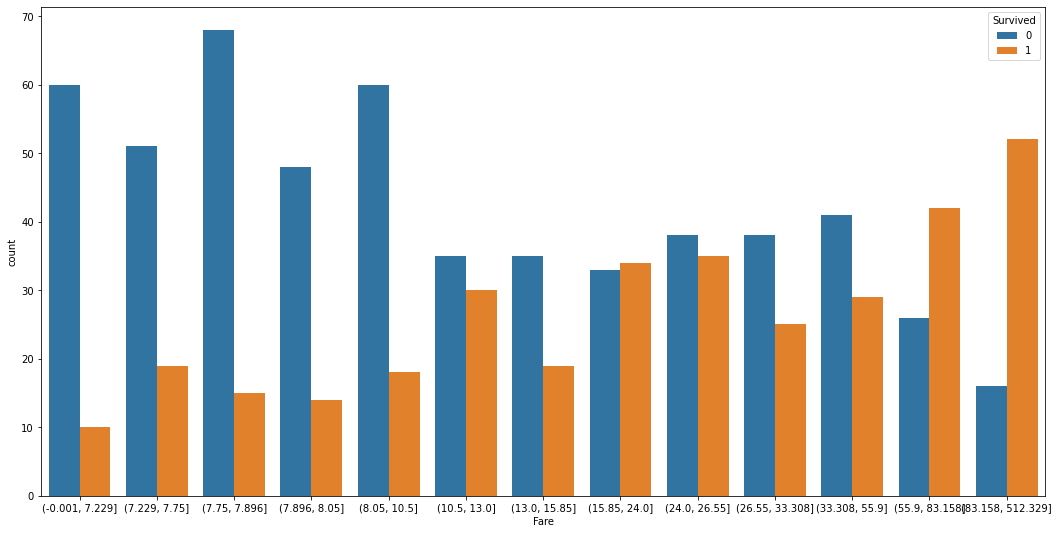

In [21]:
#The higher the fare, the higher the survival rate

train = pd.read_csv('train.csv',header=0)

train["Fare"] = pd.qcut(train['Fare'], 13)
fig, axs = plt.subplots(figsize=(18, 9))

sns.countplot(x='Fare', hue='Survived', data=train)


<AxesSubplot:xlabel='Title', ylabel='count'>

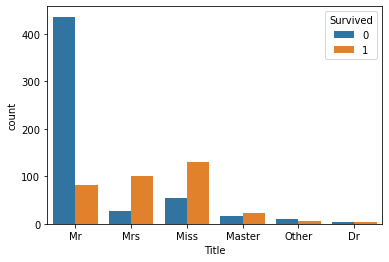

In [22]:
#Survival rate by different title group 
sns.countplot(x='Title', hue='Survived', data=train_df)

# Building Machine Learning Model

In [23]:
#Feature "Sex", "Embarked" and "Title" are object type
#Using LabelEncoder to convert them into numerical type

object_type = ['Sex', 'Embarked', 'Title']
for dataset in combine:
    for feature in object_type:
        dataset[feature] = LabelEncoder().fit_transform(dataset[feature])

In [24]:
#Drop the useless feature
drop_list=['Name','SibSp',"Parch",'Ticket','Cabin']

train_df = train_df.drop(drop_list, axis =1)
test_df = test_df.drop(drop_list, axis =1)

In [28]:
#Split the dataset into train and test data
list = ["PassengerId", "Survived"]
X_train = train_df.drop(list, axis=1)
y_train = train_df['Survived']

X_test = test_df.drop("PassengerId", axis=1).copy()

X_train.shape, y_train.shape, X_test.shape


((891, 8), (891,), (418, 8))

In [35]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_decision_tree = round(clf.score(X_train, y_train) * 100, 2)
print (acc_decision_tree)

98.43


In [40]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf.score(X_train, y_train)
acc_rf = round(rf.score(X_train, y_train) * 100, 2)
print(acc_rf)

98.43


In [36]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, y_train) * 100, 2)
acc_log

80.92

In [43]:
knn = KNeighborsClassifier(n_neighbors = 10) 
knn.fit(X_train, y_train)  
y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
print(acc_knn)

84.96


In [45]:
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
print(acc_svc)

83.95


In [47]:
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)
y_pred = abc.predict(X_test)
acc_abc = round(abc.score(X_train, y_train) * 100, 2)
print(acc_abc)

84.51


# Hyperparameter Tuning 

In [54]:
#The result of the randomforest is the highest, we will do some tuning in the following

for e in [5, 10, 50, 100, 500, 100]:
    rf = RandomForestClassifier(n_estimators=e)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    acc_rf = round(rf.score(X_train, y_train) * 100, 2)
    print (acc_rf)

95.96
96.75
98.43
98.43
98.43
98.43


In [62]:
#The best estimators: 50
#cross-validation

parameters = {
    'n_estimators'      : [50,100,150],
    'max_depth'         : [8, 9, 10, 11, 12],
    'random_state'      : [0]
}

rfcv = GridSearchCV(
    RandomForestClassifier(n_estimators = 50),
    param_grid = parameters,
    cv = 10,
    n_jobs = -1)

rfcv.fit(X_train, y_train)

print(rfcv.best_score_)
print(rfcv.score(X_train, y_train))
print(rfcv.best_params_)


0.8316978776529338
0.9315375982042648
{'max_depth': 9, 'n_estimators': 100, 'random_state': 0}


<AxesSubplot:xlabel='feature'>

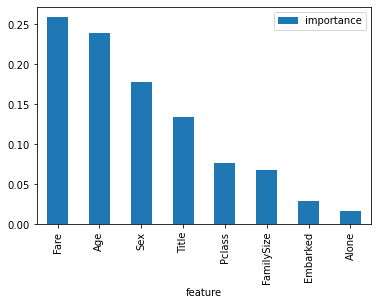

In [78]:
importance_df = train_df.drop(["PassengerId", "Survived"],axis =1 )

importances = pd.DataFrame({'feature':importance_df.columns,'importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.plot.bar()